In [19]:
!pip install fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *
from IPython.core.pylabtools import figsize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
print(fastbook.__version__)

0.0.26


In [21]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CatBreedClassifier')
path = Path('/content/drive/My Drive/CatBreedClassifier')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
classes = 'Ragdoll', 'Exotic Shorthair', 'Maine Coon', 'Persian', 'British Shorthair', 'Devon Rex', 'Abyssinian', 'American Shorthair', 'Scottish Fold', 'Sphynx', 'Oriental', 'Cornish Rex', 'Thai', 'Russian Blue', 'Bengal', 'Ocicat', 'Tonkinese'
path = Path('train') 
if not path.exists():
  path.mkdir()
  for c in classes:
    dest = (path/c)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {c} cat', max_images=200)
    download_images(dest, urls=urls)

In [23]:
for c in classes:
    img_fnames = get_image_files(path/c)
    for fname in img_fnames:
      try:
        Image.open(str(fname))
      except:
        print(f'Deleting {fname}')
        fname.unlink()

In [24]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [25]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(max_rotate=2.0)
)
dls = data.dataloaders(path, bs = 32, num_workers = 0)

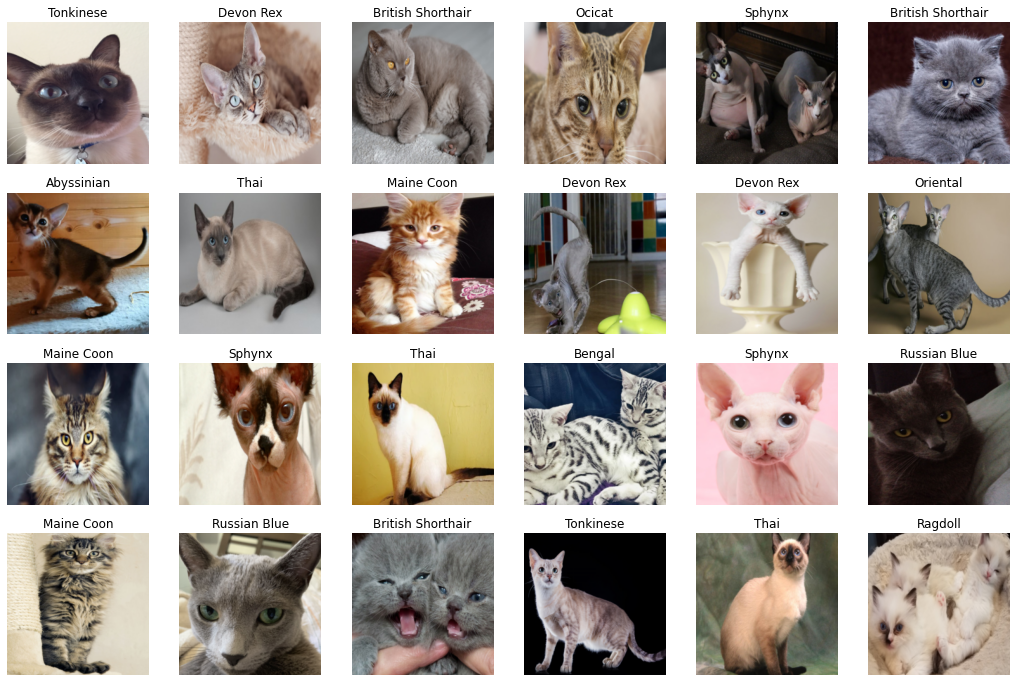

In [26]:
dls.valid.show_batch(max_n=24, nrows=4)

Model training

In [27]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


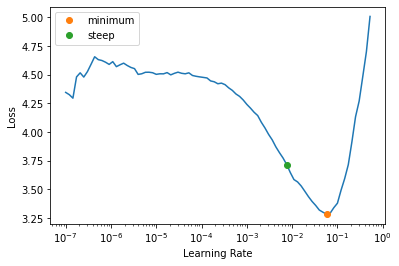

In [10]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [12]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 7.59e-03


In [57]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, F1Score(average="macro"), RocAuc(multi_class='ovr')])
learn.fine_tune(6, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,roc_auc_score,time
0,2.328369,1.042838,0.322115,0.665544,0.969263,02:13


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,f1_score,roc_auc_score,time
0,1.269776,0.847908,0.251603,0.750184,0.977922,02:16
1,1.061546,0.920709,0.259615,0.744883,0.977386,02:14
2,0.791420,0.771084,0.209936,0.789846,0.983752,02:16
3,0.622039,0.696400,0.193910,0.806334,0.984708,02:16
4,0.454483,0.690386,0.192308,0.811155,0.985783,02:16
5,0.373831,0.697821,0.187500,0.816100,0.985360,02:16


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

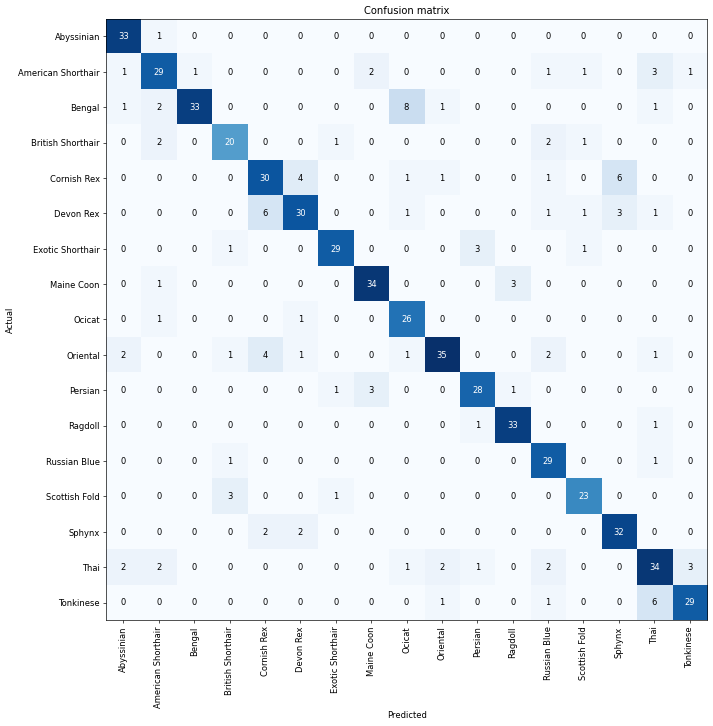

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [59]:
interp.most_confused(min_val=5)

[('Bengal', 'Ocicat', 8),
 ('Cornish Rex', 'Sphynx', 6),
 ('Devon Rex', 'Cornish Rex', 6),
 ('Tonkinese', 'Thai', 6)]

In [62]:
learn.export(fname='model_final.pkl')